# Анализ ассортимента магазина товаров для дома

## Описание проекта

Необходимо провести анализ ассортимента интернет-магазина товаров для дома и быта «Пока все ещё тут». В рамках анализа необходимо:
- исследовать данные;
- выделить категории товаров;
- выделить основной и дополнительный ассортименты внутри категорий;
- выдвинуть гипотезу о различиях между основным и дополнительным ассортиментами и проверить её; 
- подготовить презентацию с результатами исследования;
- подготовить дашборд с диаграммой количества покупок по дням, количеством покупателей и фильтрацией по дате.

Презентация и дашборд доступны по следующим ссылкам:
- [Ссылка](https://drive.google.com/file/d/1q6RaVyD1MiuUOsJOgpEtLoLazvNNLMEE/view?usp=sharing) на презентацию;
- [Ссылка](https://public.tableau.com/profile/oleg1290#!/vizhome/Orders_and_customers_dashboard/Dashboard1?publish=yes) на дашборд.

## <a name="0"> Структура проекта </a>

- [Загрузка данных и ознакомление с ними](#1)
- [Предобработка данных](#2)
- [Исследовательский анализ данных](#3)
  - [Статистические характеристики](#3.1)
  - [Поиск выбросов](#3.2)
  - [Исследование аномалий в датах заказов](#3.3)
- [Категоризация товаров](#4)
- [Выделение основного и дополнительного ассортимента](#5)
- [Проверка гипотезы](#6)
- [Общие выводы](#7)

## <a name="1"> Загрузка данных и ознакомление с ними </a>

Загрузим библиотеки для работы с таблицами, временными данными, визуализации, кластеризации и проверки гипотез:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
pd.set_option('display.max_colwidth', None)
import warnings
warnings.simplefilter('ignore')

Загрузим таблицу с данными и посмотрим на неё:

In [2]:
df = pd.read_csv('/Users/polzovatel/Desktop/Projects/Product_categorization/ecommerce_dataset.csv')
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Датасет описывает транзакции магазина. Колонки содержат следующую информацию:

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

In [3]:
df.shape

(6737, 6)

В таблице 6737 строк и 6 колонок. 

[В начало](#0)

## <a name="2"> Предобработка данных </a>

Проверим типы данных в столбцах и наличие пропусков:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


Пропусков в данных нет. 

Но основе столбца `date` создадим столбец `datetime` с датой и временем, применив маску `%Y%m%d%H`. А в самом столбце `date` оставим только дату:

In [5]:
df['datetime'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df['date'] = df['datetime'].astype('datetime64[D]')
df['date'].dtype, df['datetime'].dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'))

Полученный тип данных является типом `datetime`, в чём легко убедиться:

In [6]:
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

True

Теперь проверим наличие строк-дублей в таблице:

In [7]:
df.duplicated().sum()

0

Строк-дублей нет.

## <a name="3"> Исследовательский анализ данных </a>

### <a name="3.1"> Статистические характеристики </a>

Посмотрим на статистические характеристики данных в столбцах:

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,6737.0,43128.948345,27899.414662,12624.0,14827.0,68503.0,70504.0,73164.0
quantity,6737.0,2.501559,15.266478,1.0,1.0,1.0,1.0,1000.0
price,6737.0,462.028499,871.296064,9.0,101.0,135.0,398.0,14917.0


In [9]:
df.describe(include='O').T

,count,unique,top,freq
customer_id,6737,2451,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,888
product,6737,2343,Рассада Кабачка сорт Зебра кассета 6 шт E6,79


In [10]:
df[['date']].describe().T

,count,unique,top,freq,first,last
date,6737,394,2019-05-13,146,2018-10-01,2019-10-31


Можно вынести следующую полезную информацию:
- в среднем покупают 2,5 товара одного наименования, но есть заказ, где купили сразу 1000 одинаковых товаров;
- цены на товары колеблются от 9 до 14 917 ден. ед., а средняя цена - 462 ден. ед.;
- чаще всего (79 раз) покупали `Рассада Кабачка сорт Зебра кассета 6 шт E6`;
- диапазон рассматриваемого времени: 10 января 2018 - 31 октября 2019;
- у магазина 2451 уникальных покупателя, а ассортимент состоит из 2343 уникальных товара.

In [11]:
df['order_id'].nunique()

2784

Всего было сделано 2784 заказа.

[В начало](#0)

### <a name="3.2"> Поиск выбросов </a>

Проверим, нет ли среди заказов выбросов. Оценивать будем по суммарной выручке, которую принесли заказы. Поэтому сначала добавим столбец `revenue`, в котором перемножим стоимость товара и его количество в заказе:

In [12]:
df['revenue'] = df['quantity'] * df['price']

Теперь сгруппируем все заказы по `order_id`, найдём суммарную выручку и выведем топ-5 самых крупных заказов:

In [13]:
orders_revenue = df.groupby('order_id')['revenue'].sum().sort_values(ascending=False)
orders_revenue.head()

order_id
71743    675000.0
14833    114750.0
70960     65220.0
68760     50770.0
69531     49668.0
Name: revenue, dtype: float64

Построим диаграмму размаха (боксплот) выручек с заказов:

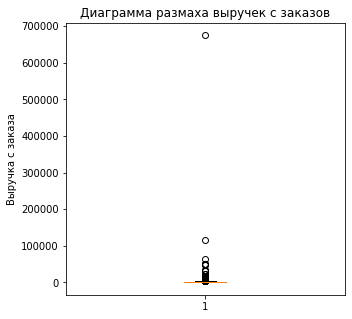

In [14]:
plt.figure(figsize=(5, 5))
plt.boxplot(orders_revenue)
plt.title("Диаграмма размаха выручек с заказов")
plt.ylabel("Выручка с заказа")
plt.show()

Хорошо заметен выброс - заказ с выручкой 675 000 ден. ед. Также возможно выбросом является следующий по размеру заказ в 114 750 ден. ед. Найдём 99 процентиль:

In [15]:
perc_99 = np.percentile(orders_revenue, 99)
perc_99

11275.500000000011

Будем считать все заказы дороже `perc_99` выбросами. Выделим их `order_id` и посчитаем количество:

In [16]:
outlier_orders = orders_revenue[orders_revenue > perc_99].index
len(outlier_orders)

28

Таких заказов 28 штук. Оставим в таблице только 99% самых дешёвых заказов:

In [17]:
df = df.query('order_id not in @outlier_orders')

Проверим, что выбросов больше нет в таблице:

In [18]:
df.query('order_id in @outlier_orders')

,date,customer_id,order_id,product,quantity,price,datetime,revenue


Посмотрим, сколько строк теперь в таблице:

In [19]:
len(df)

5450

А было 6737 строк. То есть 1287 строк (или 19%) приходились на 1% заказов, которые мы отнесли к выбросам. Мы потеряли много данных, но они и не описывали бóльшую часть заказов. Поэтому их удаление будем считать рациональным.

Проверим данные на наличие выбросов в столбце `quantity`. Для этого построим диаграмму размаха количества товаров в заказах:

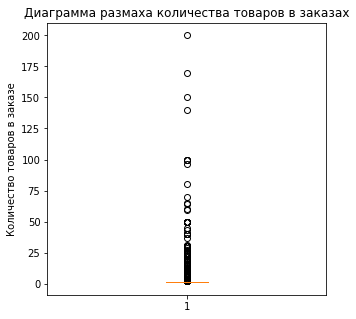

In [20]:
plt.figure(figsize=(5, 5))
plt.boxplot(df['quantity'])
plt.title("Диаграмма размаха количества товаров в заказах")
plt.ylabel("Количество товаров в заказе")
plt.show()

Большинство значений находятся в нижней части диаграммы. Выберем границей между нормальными значениями и выбросами 99 процентиль:

In [21]:
perc_99 = np.percentile(df['quantity'], 99)
perc_99

29.51000000000022

Будем считать все строчки таблицы, где значение в столбце `quantity` больше perc_99, выбросами. Удалим их из таблицы:

In [22]:
df = df.query('quantity <= @perc_99')

Посмотрим, сколько строк теперь в таблице:

In [23]:
len(df)

5395

А было 5450 строк. То есть 55 строк (или 1%) приходились заказы с аномально большим количество заказанных товаров. Мы удалили небольшое количество данных, но при этом устранили риск работы с ошибочными данными.

[В начало](#0)

### <a name="3.3"> Исследование аномалий в датах заказов </a>

Проверим, не меняется ли дата у одних и тех же заказов. Сгруппируем заказы по `order_id` и посчитаем все уникальные `date`:

In [24]:
df.groupby('order_id')['date'].nunique().sort_values(ascending=False).head()

order_id
69162    15
13547     7
70419     6
71463     6
70962     6
Name: date, dtype: int64

Несколько дат у одного и тоже заказа может означать или ошибку в данных, или специфику записи данных в БД. Если второе предположение верно, то возможно, что каждая запись - это всего лишь добавление товара в корзину на сайте.

Посмотрим, какой диапазон времени встречается у одних и тех же заказов - от добавления первого товара в корзину до последнего:

In [25]:
orders_date_range = df.groupby('order_id', as_index=False).agg({'date': ['min', 'max']})
orders_date_range.columns = ['order_id', 'min', 'max']
orders_date_range['range'] = orders_date_range['max'] - orders_date_range['min']
orders_date_range.sort_values('range', ascending=False).head()

,order_id,min,max,range
1948,71663,2019-06-10,2019-09-05,87 days
1024,69797,2019-01-12,2019-04-05,83 days
1886,71542,2019-05-28,2019-08-07,71 days
1670,71054,2019-04-07,2019-06-05,59 days
800,69310,2018-12-11,2019-02-03,54 days


Видим, что заказы собирались до 87 дней. Так как мы не можем исключить, что в данных просто ошибки, то определим границу, ниже которой будем считать, что заказ собирается, а выше - что в данных ошибка. Границей примем 7 дней.

Выберем все заказы, которые собирались более 7 дней, и посчитаем их количество:

In [26]:
outlier_orders_2 = orders_date_range.query('range > "7 days"')['order_id'].to_list()
len(outlier_orders_2)

32

Таких заказов 32 штуки. Оставим в таблице только заказы, которые собирались 7 и менее дней:

In [27]:
df = df.query('order_id not in @outlier_orders_2')

Проверим, что аномально долгих заказов больше нет в таблице:

In [28]:
df.groupby('order_id')['date'].nunique().sort_values(ascending=False).head()

order_id
70419    6
69109    4
72518    4
70115    4
70567    4
Name: date, dtype: int64

Посмотрим, сколько строк теперь в таблице:

In [29]:
len(df)

5207

А было 5395 строк. То есть 188 строк (или 3,5%) приходились на заказы, которые собирались более 7 дней. Мы потеряли относительно немного данных и при этом избавились от сомнительных заказов.

[В начало](#0)

## <a name="4"> Категоризация товаров </a>

Посчитаем количество наименований товаров после удаления выбросов и аномальных заказов:

In [30]:
df['product'].nunique()

2262

А было 2343 уникальных товара. Удалены 81 товар или 3,4% наименований.

Теперь попробуем разбить их на категории. Для этого соберём ключевые слова, которые встречаются в названиях товаров, и разложим их по тематическим спискам:

In [31]:
artificial_plants_and_fruits = ['муляж', 'искусственн', 'искуственн']

kitchen = ['термокружка', 'вилка', 'ложка', 'контейнер', 'нож', 'кувшин', 'салфет', 'овоще', 'чайник'
           , 'просеиватель', 'кухон', 'банка', 'стакан', 'кастрюля', 'чайный', 'кружка', 'сковород', 'тарелка'
           , 'противень', 'дуршлаг', 'бидон', 'термос', 'рыбочистка', 'толкушка', 'лопатка', 'скатерть', 'ковш'
           , 'холодца', 'выпечк', 'пресс', 'разделочная', 'пьезозажигалка', 'миксер', 'посуды', 'масленка'
           , 'мантоварка', 'антижир', 'картофелемялка', 'миска', 'блюдце', 'хлебница', 'блюдо', 'сахарница'
           , 'терка', 'крышка', 'яйца', 'половник', 'подушка', 'посудомоечных', 'рассекатель', 'фужеров'
           , 'кексов', 'столовых', 'орехоколка', 'бокалов', 'кружек', 'сито', 'скалка', 'отделитель', 'соко'
           , 'кондитерский', 'пищев', 'сотейник', 'котел', 'тортница', 'электроштопор', 'салатник']

bathroom = ['сиденье', 'ёрш', 'ерш', 'ванн', 'полотен', 'зубная', 'вантуз', 'мыло', 'фен', 'дозатор', 'халат'
            , 'подголовник', 'маска']

cleaning = ['сушилка', 'корыто', 'щетка', 'щётка', 'веник', 'ведро', 'пылесос', 'микрофибр', 'швабра', 'налета'
            , 'прищеп', 'гладильн', 'подрукавник', 'глажения', 'досок', 'корзина', 'насадка', 'ролика', 'мытья'
            , 'губка', 'утюг', 'подкладка', 'перчатки', 'тряпкодержатель', 'окномойка', 'отжим', 'стирки'
            , 'отбеливатель', 'совок', 'засоров', 'стиральн', 'пластмассов', 'сметка', 'алюминиев', 'чистк'
            , 'чистящ', 'белья']

furniture = ['коврик', 'обув', 'вешал', 'полки', 'комод', 'простын', 'покрывало', 'костюм', 'ящик', 'кашпо'
             , 'фоторамка', 'ковер', 'ковёр', 'плед', 'напольные', 'пуф', 'кофр', 'одежды', 'штор', 'плечики'
             , 'пододеяльник', 'наматрицник', 'наматрасник', 'одеяло', 'наволочка', 'светильник', 'мебел', 'коробка'
             , 'подставка', 'лоток', 'корзинка', 'ключница', 'урна', 'постельн', 'хранения']

instruments = ['болт', 'крючок', 'стремянк', 'фал ', 'шпагат', 'полировки', 'петля', 'скребок', 'пробки', 'крепеж'
               , 'инструмент', 'шнур', 'сварка', 'бензин', 'пружина', 'напильников', 'скоба', 'сверел', 'строительн'
               , 'сверло', 'термометр', 'вентиляц', 'короб ', 'линейка', 'угольник', 'уголок', 'фиксатор']

bags = ['тележк', 'сумка']

Для того, чтобы выделить категории, пришлось изучить товары в таблице, а именно многократно выводить значения столбца 'product'. В ходе многократных повторений выписывались ключевые слова из названий продуктов. Через какое-то время стало понятно, на какие категории по смыслу можно поделить товары. Для каждой категории был создан список, который наполнялся ключевыми словами. А чтобы при многократном повторении вывода значений столбца 'product' мы не встречали снова уже категоризированные товары, то они исключались из таблицы. Таким образом в таблице остались только товары категории "расстения и семена".

Так как в таблице встречается много расстений и семян, то чтобы не выписывать их все ключевые слова, просто отнесём к этой категории все оставшиеся товары. Итого у нас получится 8 категорий товаров.

Напишем функцию, которая определит наличие ключевого слова в названии товара и отнесёт товар к одной из категорий:

In [32]:
def to_category(product_name):
    if any(i in product_name.lower() for i in artificial_plants_and_fruits):
        return 'искусственные растения и фрукты'
    elif any(i in product_name.lower() for i in bags):
        return 'сумки-тележки и принадлежности'
    elif any(i in product_name.lower() for i in cleaning):
        return 'товары для уборки'
    elif any(i in product_name.lower() for i in kitchen):
        return 'товары для кухни'
    elif any(i in product_name.lower() for i in bathroom):
        return 'товары для с/у'
    elif any(i in product_name.lower() for i in furniture):
        return 'предметы интерьера'
    elif any(i in product_name.lower() for i in instruments):
        return 'строительные инструменты'
    else:
        return 'растения и семена'

Применим функцию и категоризируем товары:

In [33]:
df['product_category'] = df['product'].apply(to_category)

Теперь посмотрим, сколько в каждой категории наименований товаров:

In [34]:
categories_amount = df.groupby(['product', 'product_category'])[['order_id']].nunique().reset_index()\
.groupby('product_category', as_index=False)['product'].count().sort_values('product', ascending=False)
categories_amount

,product_category,product
2,растения и семена,897
7,товары для уборки,442
5,товары для кухни,299
1,предметы интерьера,209
0,искусственные растения и фрукты,130
6,товары для с/у,123
4,сумки-тележки и принадлежности,107
3,строительные инструменты,55


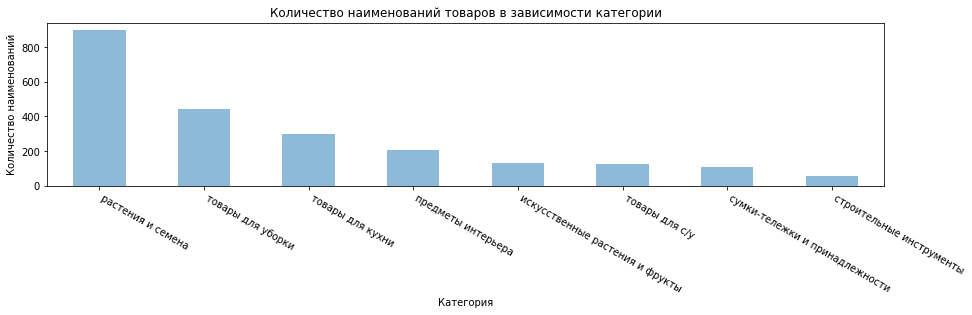

In [35]:
categories_amount.plot(x='product_category', y='product', kind='bar', figsize=(15, 3), legend=False, alpha=.5)
plt.title("Количество наименований товаров в зависимости категории")
plt.xlabel("Категория")
plt.ylabel("Количество наименований") 
plt.xticks(rotation=-30, ha='left')
plt.show()

Наибольшая по количеству наименований товаров категория - "растения и семена". В ней около 900 товаров. Наиболее специфичная и узкая - "сумки-тележки и принадлежности". Однако она достаточно большая, чтобы её выделить как отдельную категорию.

[В начало](#0)

## <a name="5"> Выделение основного и дополнительного ассортимента </a>

Внутри каждой категории выделим основной и дополнительный ассортимент. Разделять товары будем на основании двух признаков: размер принесённой выручки и популярность у покупателей (количество заказов). Для разделения воспользуемся алгоритмом KMeans, который решает задачу кластеризации с заданным количеством групп, в нашем случае - 2.

В результате работы алгоритма мы получим список всех товаров с расставленными лёйблами (к какой из двух групп они относятся). А оценить работу алгоритма наглядно мы сможем с помощью диаграмм рассеяния от признаков выручки с товара и количества заказов.

Создадим список всех категорий товаров:

In [36]:
categories = df['product_category'].unique()
categories

array(['растения и семена', 'товары для уборки', 'предметы интерьера',
       'сумки-тележки и принадлежности',
       'искусственные растения и фрукты', 'товары для кухни',
       'товары для с/у', 'строительные инструменты'], dtype=object)

Создадим таблицу для наполнения товарами и их лейблами (к какой группе из двух относятся):

In [37]:
product_labels = pd.DataFrame()

Создадим объекты класса `StandardScaler` и `KMeans` для стандартизации признаков и кластеризации объектов на основании этих стандартизированных признаков:

In [38]:
scaler = StandardScaler()
km = KMeans(n_clusters = 2, random_state=0)

Напишем цикл, в котором внутри каждой категории товара будет производиться кластеризация, лэйблы записываться в таблицу `product_labels` и выводиться диаграммы рассеяния для визуальной оценки кластеризации:

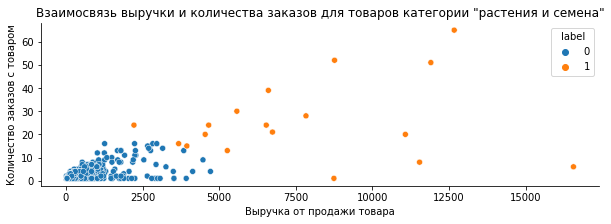

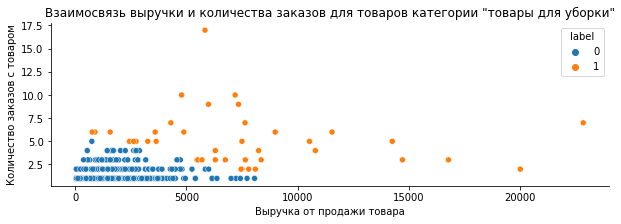

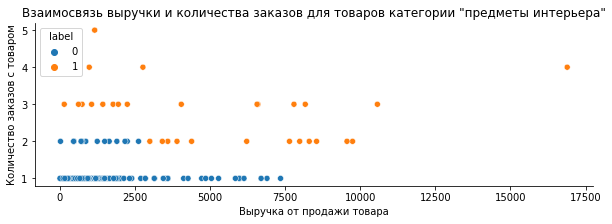

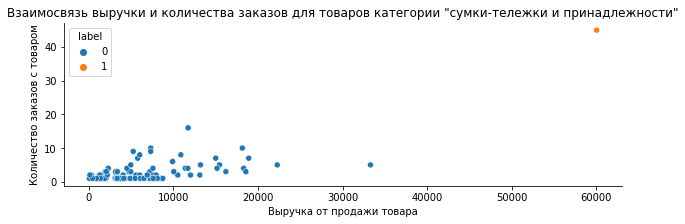

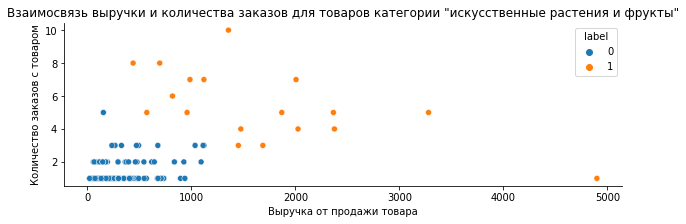

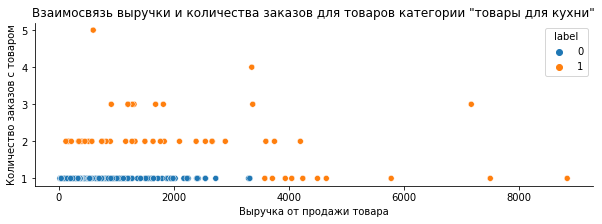

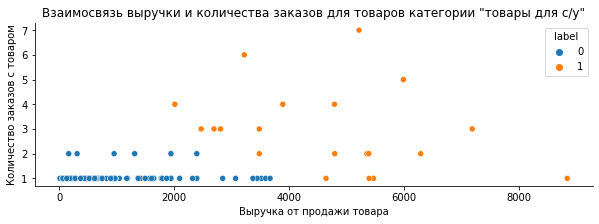

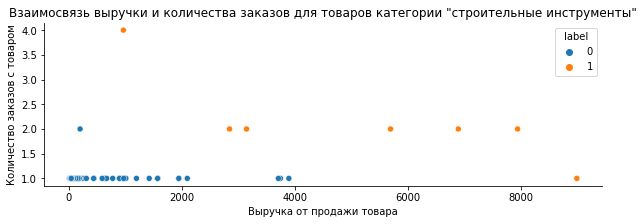

In [39]:
for category in categories:
    X = df.query('product_category == @category').groupby('product')\
    .agg({'order_id': 'nunique', 'revenue': 'sum'})
    X_sc = scaler.fit_transform(X)
    labels = km.fit_predict(X_sc)
    X['label'] = labels
    if X.query('label == 0')['revenue'].max() > X.query('label == 1')['revenue'].max():
        X['label'] = X['label'].map({0: 1, 1: 0})
    product_labels = product_labels.append(X[['label']].reset_index())
    plt.figure(figsize=(10, 3))
    sns.scatterplot(x='revenue', y='order_id', hue='label', data=X)
    sns.despine()
    plt.title(f'Взаимосвязь выручки и количества заказов для товаров категории "{category}"')
    plt.xlabel("Выручка от продажи товара")
    plt.ylabel("Количество заказов с товаром") 
    plt.show()

Можно заметить, что все товары с лэйблом `1` как правило принесли больше выручки и/или лучше продавались по сравнению с товарами с лэйблом `0`. Поэтому товары с лэйблом `1` будем считать основным ассортиментом, а с лэйблом `0` - дополнительным. 

Проверим, что все товары попали в таблицу `product_labels`:

In [40]:
product_labels.sample(5)

,product,label
57,"Муляж Виноград, желтый, 24 см, полиуретан, Fancy Fair/G60-Y",0
400,"Петуния Potunia Plus Purple бургунди с прожилками объем 0,5 л",0
108,Муляж ЯБЛОКО 9 см красное,0
728,Фаленопсис королевский Голубой 1 ствол d-12 см,0
84,"Коврик придверный каучуковый 45х75 см черный, Helex, P01",0


In [41]:
product_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2262 entries, 0 to 54
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   product  2262 non-null   object
 1   label    2262 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 53.0+ KB


В таблице 2262 товара (то есть мы ничего не потеряли) и у каждого товара теперь есть свой лэйбл.

In [42]:
product_labels['label'].value_counts()

0    2075
1     187
Name: label, dtype: int64

При этом 187 товаров относятся к основному ассортименту, а 2075 - к дополнительному.

В результате кластеризации мы получили для каждого товара лэйбл, то есть метку, к какому ассорименту он относится - основному или дополнительному. Список всех товаров с лэйблами хранится в таблице 'product_labels'.
     
В будущем при необходимости повторить такую кластеризацию, то есть деление товаров на основной и дополнительный ассортимент, нужно будет взять список товаров с признаками (в нашем случае в качестве признаков были взяты размер выручки и количество заказов, но можно использовать и другие признаки), а затем использовать алгоритм. В результате он вернёт для каждого товара его лэйбл.

[В начало](#0)

## <a name="6"> Проверка гипотезы </a>

Проверим гипотезу о том, что товары из основного ассортимента чаще покупают в одиночку, а из дополнительного - вместе с другими товарами. Если переформулировать, то проверим, что среднее количество наименований товаров в заказах с основными товарами меньше, чем в заказах с дополнительными товарами. 

Для начала создадим таблицу, в которой для каждого товара будет указано среднее количество наименований товаров в заказах, где есть этот товар:

In [43]:
products_in_orders = df.groupby('order_id')['product'].nunique().reset_index()
products_in_orders.columns = ['order_id', 'order_size']
df = df.merge(products_in_orders, on='order_id')
product_mean_order_size = df.groupby('product')['order_size'].mean().reset_index()
products = product_mean_order_size.merge(product_labels, on='product')
products.sample(5)

,product,order_size,label
238,Гладильная доска Dogrular Томрис 120x38 см,1.0,0
880,Новогоднее дерево Ель канадская Коника ртк 343 d-9 см,1.0,0
202,"Гвоздика турецкая Роковая страсть 0,05 г 4660010773231",18.0,0
224,"Герань домашняя (пеларгония зональная) цветущая D12, H25-30, ярко розовая, полумахровая",10.0,0
327,Диффенбахия d-12 см с топпером на День учителя в подарочной упаковке,1.0,0


Проверим, что все товары на месте:

In [44]:
len(products)

2262

Ничего не потеряли.

Теперь сформулируем нулевую и альтернативную гипотезы:
- H0: товары из основного и дополнительного ассортимента покупают в равных по количеству наименований товаров заказах;
- H1: товары из дополнительного ассортимента покупают в заказах с бóльшим количеством наименований товаров.

Для проверки гипотезы выберем статистический критерий. Для начала проверим распределение товаров в зависимости от размера заказов, в которых они есть:

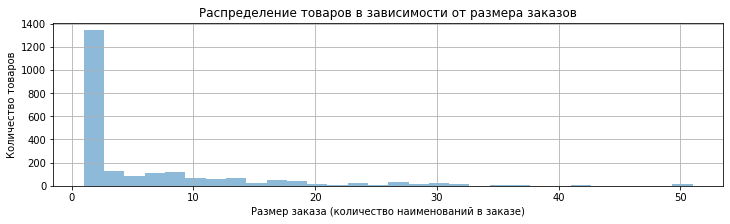

In [45]:
plt.figure(figsize=(12, 3))
products['order_size'].hist(bins=30, alpha=.5)
plt.title("Распределение товаров в зависимости от размера заказов") 
plt.xlabel("Размер заказа (количество наименований в заказе)")
plt.ylabel("Количество товаров") 
plt.show()

Так как распределение далеко от нормального, то для проверки гипотезы будем использовать непараметрический критерий Манна-Уитни. Критическим значением альфа примем 0,05. Воспользуемся функцией `mannwhitneyu` и найдём p-value:

In [46]:
st.mannwhitneyu(products.query('label == 0')['order_size'], products.query('label == 1')['order_size']
                          , alternative='greater').pvalue

5.675057176068563e-09

Так как p-value оказалось значительно меньше альфа, то у нас есть основания отклонить нулевую гипотезу. То есть мы можем считать, что товары из дополнительного ассортимента покупают в заказах с бóльшим количеством наименований товаров заказах, чем товары из основного ассортимента.

Если посчитать средний размер заказов, где есть товар из основного ассортимента, и заказов, где есть товар из дополнительного ассортимента, то можно увидеть, что разница достаточно большая и очевидна без проверки статистическими критериями:

In [47]:
products.groupby('label')['order_size'].mean()

label
0    6.243903
1    2.153542
Name: order_size, dtype: float64

Заказы с товарами из основного ассортимента примерно в 3 раза меньше по количеству наименований, чем заказы с товарами из дополнительного ассортимента.

Если построить диаграммы размаха, то также можно увидеть разницу в распределении размеров заказов:

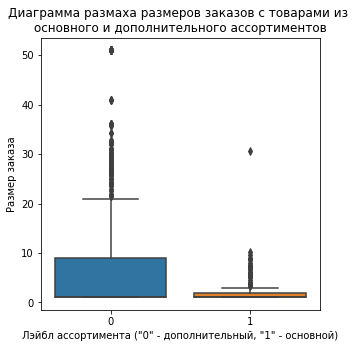

In [48]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='label', y='order_size', data=products)
plt.title("Диаграмма размаха размеров заказов с товарами из \nосновного и дополнительного ассортиментов")
plt.ylabel("Размер заказа")
plt.xlabel('Лэйбл ассортимента ("0" - дополнительный, "1" - основной)')
plt.show()

## <a name="7"> Общие выводы </a>

В результате анализа ассортимента интернет-магазина товаров для дома и быта «Пока все ещё тут» были получены следующие результаты:
- выяснили, что ассортимент магазина представлен 2282 уникальными товарами;
- поделили все товары на 8 категорий, среди которых: 
  - "растения и семена" - 897 товаров;
  - "товары для уборки" - 442 товаров;
  - "товары для кухни" - 299 товаров;
  - "предметы интерьера" - 209 товаров;
  - "искусственные растения и фрукты" - 130 товаров;
  - "товары для с/у" - 123 товаров;
  - "сумки-тележки и принадлежности" - 107 товаров;
  - "строительные инструменты" - 55 товаров.
- внутри каждой категории поделили товары на основной и дополнительный ассортименты исходя из размера принесённой выручки и количества заказов;
- выдвинули и проверили гипотезу о том, что заказы с товарами из основного ассортимента меньше по количеству наименований, чем заказы с товарами из дополнительного ассортимента. Выяснилось, что заказы с товарами из основного ассортимента примерно в 3 раза меньше. Такое различие оказалось статистически значимым;
- подготовили презентацию проведённого исследования. Она доступна по [ссылке](https://drive.google.com/file/d/1q6RaVyD1MiuUOsJOgpEtLoLazvNNLMEE/view?usp=sharing);
- сделали дашборд с диаграммой количества покупок по дням, количеством покупателей и фильтрацией по дате. Он доступен по [ссылке](https://public.tableau.com/profile/oleg1290#!/vizhome/Orders_and_customers_dashboard/Dashboard1?publish=yes).

[В начало](#0)